<a href="https://colab.research.google.com/github/AlexPJ/plant_illness_regression/blob/main/BASF_%7C_Plant_illness_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installations

In [ ]:
# MLFlow Install
!pip install mlflow --quiet

     |████████████████████████████████| 16.9 MB 32.6 MB/s 
     |████████████████████████████████| 182 kB 69.3 MB/s 
     |████████████████████████████████| 79 kB 9.7 MB/s 
     |████████████████████████████████| 209 kB 72.1 MB/s 
     |████████████████████████████████| 77 kB 7.6 MB/s 
     |████████████████████████████████| 147 kB 67.8 MB/s 
     |████████████████████████████████| 78 kB 8.5 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 140 kB 73.4 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 59 kB 8.0 MB/s 


## Packages

In [ ]:
# Importing packages
import requests
import mlflow
import IPython
import os
import datetime
import subprocess
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from random import random, sample
from math import ceil
import PIL
import PIL.Image
import matplotlib.pyplot as plt

## Global Variables

### Config. Variables

In [ ]:
#@title Enter Repository Config. Data
REPO_NAME= "plant_illness_regression" #@param {type:"string"}
REPO_OWNER= "alejandro.padilla.j" #@param {type:"string"}
USER_NAME = "alejandro.padilla.j" #@param {type:"string"}

In [ ]:
os.environ['MLFLOW_TRACKING_USERNAME'] = USER_NAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'ec6f86e409b710578137c313893bbe261fe70816'

mlflow.set_tracking_uri(f'https://dagshub.com/{REPO_OWNER}/{REPO_NAME}.mlflow')

### Experiment Variables

In [ ]:
#@title Image Related
img_height = 227  #@param {type:"integer"}
img_width = 227   #@param {type:"integer"}

In [ ]:
#@title Model Related
batch_size = 50   #@param {type:"integer"}

## Functions Definition

In [ ]:
def randomSample(full_list: list, split_size: float):
  sample_extract = sample(full_list,ceil(len(full_list)*(1-split_size)))
  rest_extract = [i for i in full_list if i['name'] not in [t['name'] for t in sample_extract]]

  return sample_extract, rest_extract

In [ ]:
def load_data(data_dir: str, annotations_file: str, test_size: float) -> list:
  images = []

  with open(f'{data_dir}/{annotations_file}',"r") as fp:
    line = fp.readline()
    while line:
      if '.png' in line:
        img_name, img_score = line.split('\t')
        img_score = int(img_score.replace('\n',''))
        image = tf.keras.utils.load_img(
                  f'{data_dir}/{img_name}',
                  grayscale=False,
                  color_mode="rgb",
                  target_size=(img_height,img_width),
                  interpolation="nearest",
            )
        img_array = tf.keras.preprocessing.image.img_to_array(image)
        images.append(
              {'name':img_name, 
               'score':img_score, 
               'image':image, 
               'array':img_array}
        )
      line = fp.readline()
    
  train, test = randomSample(images, test_size)
  return train, test

In [ ]:
def removeChannel(img_array: np.array = None, channel_list: list = []) -> np.array:
  channels = {'R':0,'G':1,'B':2}
  for channel in channel_list:
    img_array[:,:,channels[channel.upper()]] = np.zeros([img_array.shape[0], img_array.shape[1]])

  return img_array

In [ ]:
def rgb2gray(rgb: np.array) -> np.array:
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

## Our Data

### Data Download

In [ ]:
# Constants & Global vars
file_name = 'challenge.zip' 
data_url = f'https://www.dropbox.com/s/3c1abrf7w3f1fat/{file_name}?dl=0'
data_dir = f'/content/{file_name[:-4]}'

In [ ]:
# Download data from DropBox
subprocess.run(["wget","-O",file_name,data_url])

CompletedProcess(args=['wget', '-O', 'challenge.zip', 'https://www.dropbox.com/s/3c1abrf7w3f1fat/challenge.zip?dl=0'], returncode=0)

In [ ]:
# Unzip file
zip_ref = zipfile.ZipFile(f'{data_dir}.zip', 'r')
zip_ref.extractall(data_dir)
zip_ref.close()

In [ ]:
fileList = subprocess.run(['ls',data_dir],capture_output=True).stdout.decode('utf-8').split('\n')

In [ ]:
# How many of the files are images?
len([f for f in fileList if '.png' in f])

144

In [ ]:
# How many are not?
[f for f in fileList if '.png' not in f]

['challenge_anno.txt', 'Image Regression Challenge.docx', '']

### Train, Validation, & Test Splitting

In [ ]:
# Train/Test splitting
train_ds, test_ds = load_data(
                      data_dir=data_dir,
                      annotations_file='challenge_anno.txt',
                      test_size=0.3
                    )

train_ds, valid_ds = randomSample(train_ds, 0.2)

print(f'Train size: {len(train_ds)}')
print(f'Valid size: {len(valid_ds)}')
print(f'Test size: {len(test_ds)}')

Train size: 81
Valid size: 20
Test size: 43


### Training Dataset Selection

In [ ]:
#x_train = np.array([rgb2gray(x['array']) for x in train_ds]) / 255
#x_train = np.array([x['array'][:,:,1] for x in train_ds]) / 255
x_train = np.array([x['array'] for x in train_ds]) / 255
y_train = np.array([y['score'] for y in train_ds])

#x_valid = np.array([rgb2gray(x['array']) for x in valid_ds]) / 255
#x_valid = np.array([x['array'][:,:,1] for x in valid_ds]) / 255
x_valid = np.array([x['array'] for x in valid_ds]) / 255
y_valid = np.array([y['score'] for y in valid_ds])

#x_test = np.array([rgb2gray(x['array']) for x in test_ds]) / 255
#x_test = np.array([x['array'][:,:,1] for x in test_ds]) / 255
x_test = np.array([x['array'] for x in test_ds]) / 255
y_test = np.array([y['score'] for y in test_ds])

In [ ]:
x_train.shape

(81, 227, 227, 3)

### Visual Analysis

In [ ]:
sorted_images = sorted(train_ds, key=lambda x: x['score'],reverse=True)

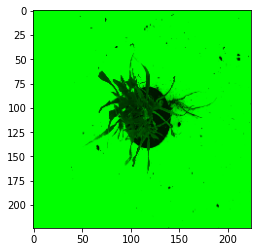

In [ ]:
img = sorted_images[0].copy()
plt.imshow(tf.keras.preprocessing.image.array_to_img(
    removeChannel(img['array'],['r','b'])
))

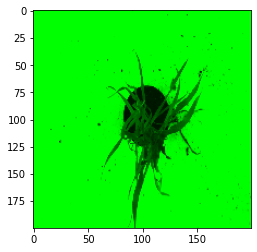

In [ ]:
img = sorted_images[-1].copy()
plt.imshow(tf.keras.preprocessing.image.array_to_img(
    removeChannel(img['array'],['r','b'])
))

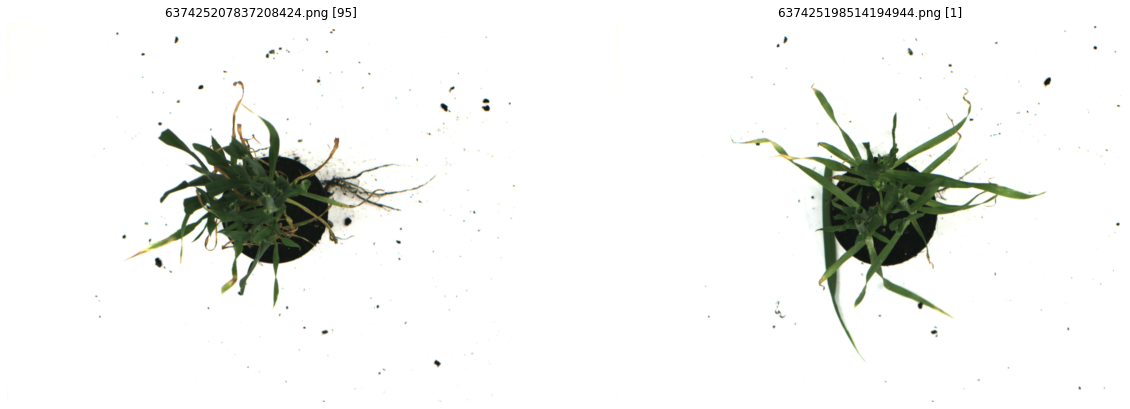

In [ ]:
# Show a most infected Vs. least infected images
plt.figure(figsize=(20,10))
for i in range(2):
  ax = plt.subplot(1, 2, i + 1)
  img = sorted_images[-i]
  _img = PIL.Image.open(f'{data_dir}/{img["name"]}')
  plt.imshow(_img)
  plt.title(f'{img["name"]} [{img["score"]}]')
  plt.axis("off")
  

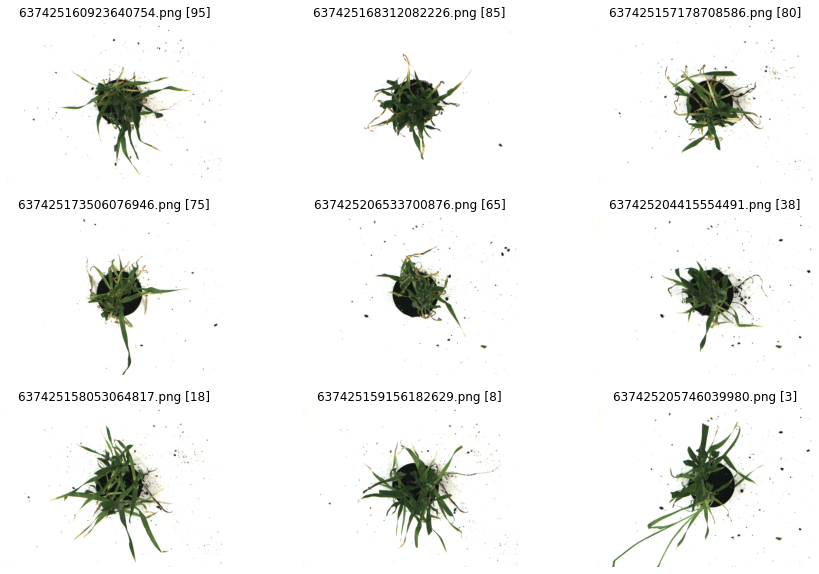

In [ ]:
# Show a preview of the images
q = 9
plt.figure(figsize=(15,10))
for i in range(q):
  ax = plt.subplot(3, 3, i + 1)
  img = sorted_images[ceil(len(sorted_images)/q*i)]
  plt.imshow(PIL.Image.open(f'{data_dir}/{img["name"]}'))
  plt.title(f'{img["name"]} [{img["score"]}]')
  plt.axis("off")
  

## The Model

### GPU Activation

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6160888183569115075
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14444920832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17692793770469180363
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


### Set MLflow Auto-Logging

In [ ]:
 mlflow.tensorflow.autolog()

2

### TF Model Configuration

In [ ]:
input_shape = x_train[0].shape
models = {
    'Custom1':[ # My lame attempt xD
        tf.keras.layers.Dense(units=500, input_shape=input_shape),
        tf.keras.layers.Dense(units=200, kernel_initializer='normal', activation="relu"),
        tf.keras.layers.MaxPool2D(strides=(2,2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(units=100, activation="relu"),
        tf.keras.layers.MaxPool2D(strides=(2,2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units=100, kernel_initializer='normal', activation="relu"),
        tf.keras.layers.Dense(units=20, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units=1, kernel_initializer='normal', activation='sigmoid')
    ],
    'BookCoverPriece':[
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ],
    'AgeDetection':[ # Winner !!  *input_shape=(100,100,1)
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), input_shape=input_shape, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(1)
    ],
    'AlexNet':[ #  *input_shape=(227,227,3)
        tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ],
    'VGG11':[ # *input_shape=(224,224,3)
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)),
        tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
}

## See the Experiment Results - LIVE! 📳

In this tab, you can see the results of the experiment while it's running!

**Notice**: To update the experiment status, simply go back to the "Experiment Tab" and reopen the top experiment in the table.

In [ ]:
display(IPython.display.IFrame(f"https://dagshub.com/{REPO_OWNER}/{REPO_NAME}/experiments/#/",'100%',600))

In [ ]:
class CustomCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if((logs.get('mean_absolute_percentage_error')<40) &
         (logs.get('val_mean_absolute_percentage_error')<75) ):
        print("\n 10% MAPE reached")
        self.model.stop_training = True

# NN Model
model = tf.keras.models.Sequential(models["AlexNet"])

learning_rate=0.001
model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate),metrics=['mean_absolute_percentage_error'])
model.summary()

# Train
history = model.fit(
    x_train,
    y_train,
    epochs=1000,
    batch_size=25,
    callbacks=[CustomCallbacks()],
    validation_data = (x_valid, y_valid)
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_26 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_27 (Bat  (None, 27, 27, 256)      1024      
 chNormalization)                                                
                                                        

2022/10/10 22:04:33 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220929150707) contains a local version label (+zzzcolab20220929150707). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/10/10 22:04:45 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp47oba4vw/model, flavor: keras), fall back to return ['tensorflow==2.8.2', 'keras==2.8.0']. Set logging level to DEBUG to see the full traceback.


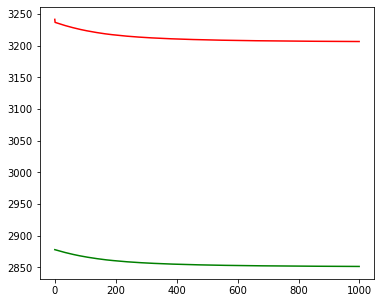

In [ ]:
plt.figure(figsize=(6, 5))
# training loss
plt.plot(history.history['loss'], color='r')
#validation loss
plt.plot(history.history['val_loss'], color='g')
plt.show()

In [ ]:
 mlflow.log_param("y_test",list(y_test))

[18,
 33,
 60,
 10,
 23,
 23,
 70,
 85,
 90,
 95,
 95,
 25,
 6,
 80,
 80,
 90,
 80,
 75,
 35,
 6,
 90,
 95,
 80,
 63,
 14,
 83,
 6,
 5,
 1,
 80,
 18,
 3,
 95,
 60,
 25,
 18,
 60,
 1,
 6,
 6,
 8,
 2,
 90]

In [ ]:
y_pred = np.round(model.predict(x_test)).reshape(y_test.shape).astype('int')
mlflow.log_param("y_pred",y_pred)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
mlflow.log_metric("difference: ",y_test - y_pred)

array([17, 32, 59,  9, 22, 22, 69, 84, 89, 94, 94, 24,  5, 79, 79, 89, 79,
       74, 34,  5, 89, 94, 79, 62, 13, 82,  5,  4,  0, 79, 17,  2, 94, 59,
       24, 17, 59,  0,  5,  5,  7,  1, 89])

In [ ]:
mlflow.log_metric("Test MAPE: ",
                  np.ma.extras.average(abs(y_test - y_pred)/y_test))  

0.8878616847645735

In [ ]:
threshold = 10
correct_obs = (abs(y_test - y_pred) <= threshold)
total_correct_obs = correct_obs.sum()
total_obs = y_test.shape[0]

mlflow.log_param("Total obs: ", total_obs)
mlflow.log_param("Correct obs: ", total_correct_obs)
mlflow.log_param("Score %: ", round(total_correct_obs/total_obs*100,2))

27.91

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


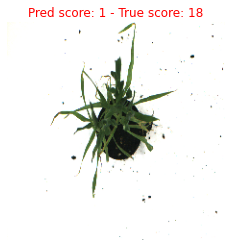

In [ ]:
for i in range(len(y_test)):
    fig = plt.figure()
    plt.imshow(x_test[i]), plt.axis('off')
    if correct_obs[i]:
        plt.title(f'Pred score: {str(y_pred[i])} - True score: {str(y_test[i])}', color='g')
    else :
        plt.title(f'Pred score: {str(y_pred[i])} - True score: {str(y_test[i])}', color='r')
    plt.axis("off")  
    mlflow.log_figure(fig, f'Prediction_{i}.png')
    